# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 2: CNN Model Development**  
Aims:  
&nbsp; 1): Generate training and test images  
&nbsp; 2): Construct CNN models (a CNN model by own, Xception, VGG16, VGG19, Resnet, Inception, InceptionResnet)  
&nbsp; 3): Tune the hyperparameters of CNN models (hyperparameter optimization)  

## Import libraries

In [1]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import  ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import  Xception
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,precision_recall_fscore_support
import datetime
import time
import tensorflow.keras as keras
import tensorflow.keras.callbacks as kcallbacks
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sklearn.metrics as metrics

2022-07-29 15:20:51.040441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Generate Training and Test Images

In [2]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

train_rootdir = './train_224/'
test_rootdir = './test_224/'

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_rootdir,
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        test_rootdir,
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
num_class = train_generator.num_classes

Found 5588 images belonging to 10 classes.
Found 1396 images belonging to 10 classes.


In [ ]:
test_labels = []
test_images=[]
for subdir, dirs, files in os.walk(test_rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_labels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))

label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [ ]:
def get_prediction(model, test_images=test_images, label=label, batch_size=BATCHSIZE):
    predict=[]
    length=len(test_images)
    for i in range(((length-1)//batch_size)+1):
        inputimg=test_images[batch_size*i:batch_size*(i+1)]
        test_batch=[]
        for path in inputimg:
            thisimg=np.array(Image.open(path))/255
            test_batch.append(thisimg)
        # thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        # test_shape=(1,)+thisimg.shape
        # thisimg=thisimg.reshape(test_shape)
        model_batch=model.predict(np.array(test_batch)) #use master model to process the input image
        #generate result by model 1
        # prob=model_batch[0,np.argmax(model_batch,axis=1)[0]]
        predict_batch=list(np.argmax(model_batch,axis=1))
        predict_batch=[label[con] for con in predict_batch]
        predict.extend(predict_batch)
    return predict

### Define the image plotting functions

In [3]:
#plot the figures
#when extra_data enabled please put this callback before early_stopping in case of any problem
class LossHistory(keras.callbacks.Callback):
    def __init__(self, need_extra_data:bool=True, test_images=test_images, test_labels=test_labels, label=label):
        # Enable the recording of precision, recall, f1-score (only epoch-wise)
        self.extra_data = need_extra_data
        if need_extra_data:
            self.test_images = test_images
            self.test_labels = test_labels
            self.label = label
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
        # need extra data --> reset recording list
        # These matrics only make sense over the entire epoch
        if self.extra_data:
            self.precision = []
            self.recall = []
            self.f1_score = []
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        # need extra data --> calculate and record
        if self.extra_data:
            # Get prediciton
            temp = self.model.stop_training
            y_pred = get_prediction(model=self.model, test_images=self.test_images, label=self.label)
            self.model.stop_training = temp
            # Calculate extra data
            precision,recall,fscore,_= precision_recall_fscore_support(self.test_labels, y_pred, average='weighted', zero_division=0)
            # Record
            self.precision.append(precision)
            self.recall.append(recall)
            self.f1_score.append(fscore)
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        else:
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()
    def get_best(self, target_type:str='epoch', need_extra_data:bool=True):
        # Get the index of the best record
        max_index = self.accuracy[target_type].index(max(self.accuracy[target_type]))
        # Return the accuracy, loss, val_acc, val_loss of the best record
        temp={
            'accuracy': self.accuracy[target_type][max_index], 
            'loss': self.losses[target_type][max_index], 
            'val_acc': self.val_acc[target_type][max_index], 
            'val_loss': self.val_loss[target_type][max_index]
            }
        # Add extra data if needed and available
        if self.extra_data and need_extra_data and target_type=='epoch':
            temp['precision']=self.precision[max_index]
            temp['recall']=self.recall[max_index]
            temp['f1-score']=self.f1_score[max_index]
        return temp

In [4]:
history_this = LossHistory(need_extra_data=True)
history_hpo = LossHistory(need_extra_data=False)

### Define the processing time measurement functions

In [5]:
# Measure the running time of model training
class TimeMeasurement(keras.callbacks.Callback):
    def __init__(self):
        self.start_time=None
        self.stop_time=None
    # Start timing when trainning starts
    def on_train_begin(self, logs=None):
        self.start_time=time.time()
        self.stop_time=None
    # Stop timing when trainning ends
    def on_train_end(self, logs=None):
        self.stop_time=time.time()
        if self.start_time is None: print("Time Measuring Failed")
    # Get processing time
    def get_processing_time(self):
        if (self.start_time is None or self.stop_time is None): raise Exception("Wrong Time Measurement")
        else: return self.stop_time-self.start_time

In [6]:
timer = TimeMeasurement()

### Define the output sheet

In [7]:
class output_sheet:
    def __init__(self, columns:list=['accuracy', 'loss', 'val_acc', 'val_loss', 'precision', 'recall', 'f1-score', 'hpo_time', 'train_time']):
        self.output_df = pd.DataFrame(columns=columns)
        # self.output_index = list()
    def add(self, item:str, **values:dict):
        # self.output_df = self.output_df.append(values, ignore_index=True)
        temp = pd.DataFrame(values, columns=self.output_df.columns.to_list(), index=[item])
        self.output_df = pd.concat([self.output_df, temp], axis=0)
        # self.output_index.append(item)
    # def apply_index(self):
    #     self.output_df.index = self.output_index
    def to_excel(self, path=None):
        if path is None: path='2-result-{}.xlsx'.format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))
        # self.apply_index()
        self.output_df.to_excel(path)

In [8]:
output = output_sheet(columns=['accuracy', 'loss', 'val_acc', 'val_loss', 'precision', 'recall', 'f1-score', 'hpo_time', 'train_time'])

# Construct CNN models

### Model 1: a CNN model by own (baseline)

In [10]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5',history=history_this,timer=timer):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

2022-07-29 14:52:12.717053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-29 14:52:12.756358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:4f:00.0
2022-07-29 14:52:12.756379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-29 14:52:12.760070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-29 14:52:12.761920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-07-29 14:52:12.762149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-07-29 14:52:12.762561: I tensorflow/stream_executor/platform

Epoch 1/20


2022-07-29 14:52:14.095361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-29 14:52:14.952792: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


11/44 [======>.......................] - ETA: 28s - loss: 0.5930 - acc: 0.8617
Epoch 00001: val_acc improved from -inf to 0.86175, saving model to ./model_own.h5
44/44 [==============================] - 54s 1s/step - loss: 0.8838 - acc: 0.8321 - val_loss: 0.5930 - val_acc: 0.8617
Epoch 2/20
11/44 [======>.......................] - ETA: 19s - loss: 0.5436 - acc: 0.8617
Epoch 00002: val_acc did not improve from 0.86175
44/44 [==============================] - 27s 613ms/step - loss: 0.6520 - acc: 0.8516 - val_loss: 0.5436 - val_acc: 0.8617
Epoch 3/20
11/44 [======>.......................] - ETA: 19s - loss: 0.2889 - acc: 0.8897
Epoch 00003: val_acc improved from 0.86175 to 0.88968, saving model to ./model_own.h5
44/44 [==============================] - 28s 642ms/step - loss: 0.4954 - acc: 0.8579 - val_loss: 0.2889 - val_acc: 0.8897
Epoch 4/20
11/44 [======>.......................] - ETA: 19s - loss: 0.2426 - acc: 0.9384
Epoch 00004: val_acc improved from 0.88968 to 0.93840, saving model t

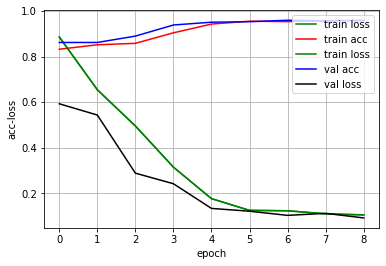

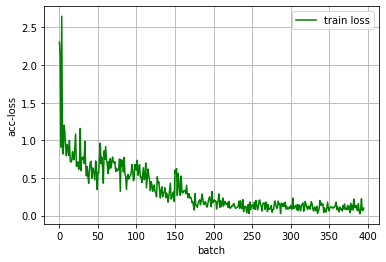

In [11]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=num_class,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of a CNN by own: 99.884%

In [12]:
output.add('model_own', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 2: Xception

In [14]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )


Epoch 1/20
11/44 [======>.......................] - ETA: 29s - loss: 0.9490 - acc: 0.8617
Epoch 00001: val_acc improved from -inf to 0.86175, saving model to ./xception.h5
44/44 [==============================] - 42s 950ms/step - loss: 0.5320 - acc: 0.8805 - val_loss: 0.9490 - val_acc: 0.8617
Epoch 2/20
11/44 [======>.......................] - ETA: 19s - loss: 1.3788 - acc: 0.8617
Epoch 00002: val_acc did not improve from 0.86175
44/44 [==============================] - 27s 615ms/step - loss: 0.1906 - acc: 0.9554 - val_loss: 1.3788 - val_acc: 0.8617
Epoch 3/20
11/44 [======>.......................] - ETA: 19s - loss: 1.6576 - acc: 0.8617
Epoch 00003: val_acc did not improve from 0.86175
44/44 [==============================] - 27s 607ms/step - loss: 0.1273 - acc: 0.9664 - val_loss: 1.6576 - val_acc: 0.8617
Epoch 4/20
11/44 [======>.......................] - ETA: 19s - loss: 1.6332 - acc: 0.8617
Epoch 00004: val_acc did not improve from 0.86175
44/44 [==============================] - 2

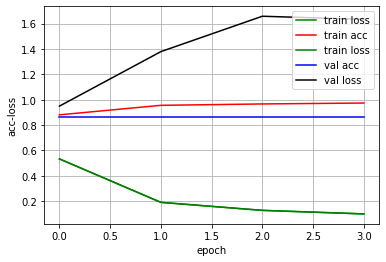

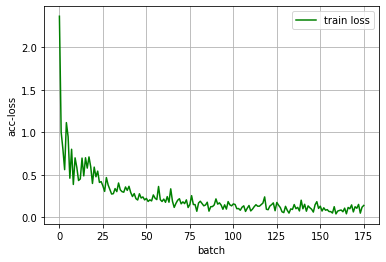

In [15]:
#default only 50, tf36cnn 99
xception(num_class=num_class,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Xception: 100.0%

In [16]:
output.add('Xception', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 3: VGG16

In [10]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )


2022-07-29 15:21:07.367378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-29 15:21:07.402693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:4f:00.0
2022-07-29 15:21:07.402715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-29 15:21:07.406546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-29 15:21:07.408395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-07-29 15:21:07.408631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-07-29 15:21:07.409049: I tensorflow/stream_executor/platform

Epoch 1/20


2022-07-29 15:21:09.557656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-29 15:21:10.407034: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


11/44 [======>.......................] - ETA: 30s - loss: 0.1548 - acc: 0.9470
Epoch 00001: val_acc improved from -inf to 0.94699, saving model to ./VGG16.h5
44/44 [==============================] - 42s 950ms/step - loss: 0.4970 - acc: 0.8631 - val_loss: 0.1548 - val_acc: 0.9470
Epoch 2/20
11/44 [======>.......................] - ETA: 19s - loss: 0.1255 - acc: 0.9527
Epoch 00002: val_acc improved from 0.94699 to 0.95272, saving model to ./VGG16.h5
44/44 [==============================] - 27s 611ms/step - loss: 0.1654 - acc: 0.9431 - val_loss: 0.1255 - val_acc: 0.9527
Epoch 3/20
11/44 [======>.......................] - ETA: 19s - loss: 0.1083 - acc: 0.9570
Epoch 00003: val_acc improved from 0.95272 to 0.95702, saving model to ./VGG16.h5
44/44 [==============================] - 27s 609ms/step - loss: 0.1308 - acc: 0.9522 - val_loss: 0.1083 - val_acc: 0.9570
Epoch 4/20
11/44 [======>.......................] - ETA: 19s - loss: 0.0877 - acc: 0.9628
Epoch 00004: val_acc improved from 0.95702

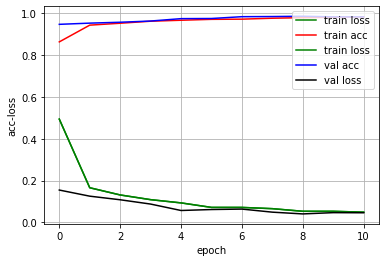

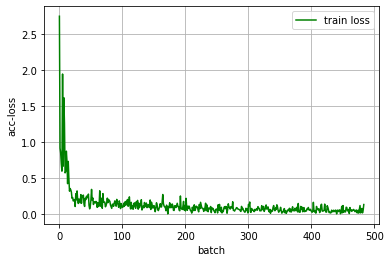

In [11]:
vgg16(num_class=num_class,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG16: 100.0%

In [12]:
output.add('VGG16', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 4: VGG19

In [13]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )


Epoch 1/20
183/183 [==============================] - 78s 429ms/step - loss: 0.0089 - acc: 0.9968 - val_loss: 1.0405e-07 - val_acc: 1.0000
Epoch 2/20
183/183 [==============================] - 75s 411ms/step - loss: 4.4981e-06 - acc: 1.0000 - val_loss: 1.0396e-07 - val_acc: 1.0000
Epoch 3/20
183/183 [==============================] - 75s 409ms/step - loss: 0.0051 - acc: 0.9992 - val_loss: 1.0384e-07 - val_acc: 1.0000
Epoch 00003: early stopping


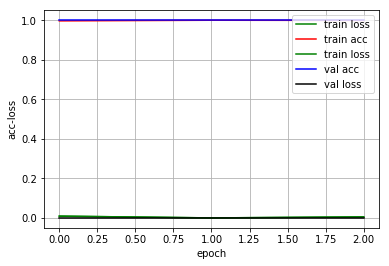

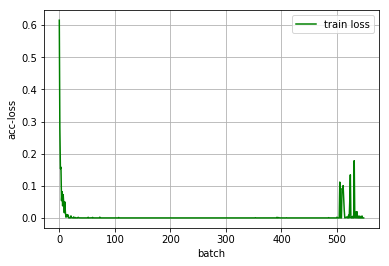

In [14]:
vgg19(num_class=num_class,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG19: 100.0%

In [ ]:
output.add('VGG19', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 5: ResNet

In [15]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

Epoch 1/20
183/183 [==============================] - 109s 594ms/step - loss: 0.0431 - acc: 0.9956 - val_loss: 0.8699 - val_acc: 0.9457
Epoch 2/20
183/183 [==============================] - 86s 471ms/step - loss: 0.2351 - acc: 0.9852 - val_loss: 0.8699 - val_acc: 0.9457
Epoch 3/20
183/183 [==============================] - 86s 472ms/step - loss: 0.2357 - acc: 0.9853 - val_loss: 0.8699 - val_acc: 0.9457
Epoch 4/20
183/183 [==============================] - 86s 470ms/step - loss: 0.2603 - acc: 0.9835 - val_loss: 0.9563 - val_acc: 0.9241
Epoch 5/20
183/183 [==============================] - 88s 481ms/step - loss: 0.4327 - acc: 0.9729 - val_loss: 0.3270 - val_acc: 0.9729
Epoch 6/20
183/183 [==============================] - 86s 472ms/step - loss: 0.2346 - acc: 0.9854 - val_loss: 0.2187 - val_acc: 0.9865
Epoch 7/20
183/183 [==============================] - 87s 477ms/step - loss: 0.2346 - acc: 0.9854 - val_loss: 0.2161 - val_acc: 0.9865
Epoch 8/20
183/183 [==============================] - 

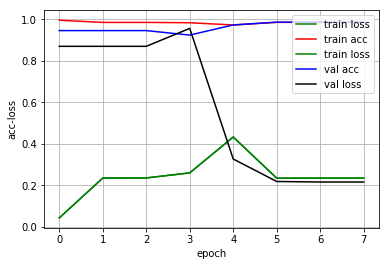

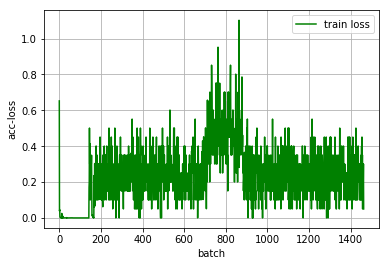

In [16]:
resnet(num_class=num_class,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Resnet: 98.652%

In [ ]:
output.add('Resnet', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 6: Inception

In [17]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

Epoch 1/20
183/183 [==============================] - 163s 892ms/step - loss: 0.0315 - acc: 0.9909 - val_loss: 6.0914 - val_acc: 0.6161
Epoch 2/20
183/183 [==============================] - 92s 500ms/step - loss: 0.0144 - acc: 0.9932 - val_loss: 0.0021 - val_acc: 0.9997
Epoch 3/20
183/183 [==============================] - 93s 509ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 5.0573e-05 - val_acc: 1.0000
Epoch 4/20
183/183 [==============================] - 93s 506ms/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.2731 - val_acc: 0.9811
Epoch 5/20
183/183 [==============================] - 93s 507ms/step - loss: 3.6954e-04 - acc: 0.9999 - val_loss: 9.7136e-05 - val_acc: 0.9999
Epoch 00005: early stopping


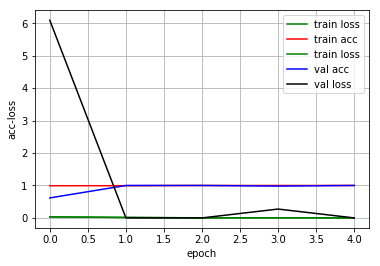

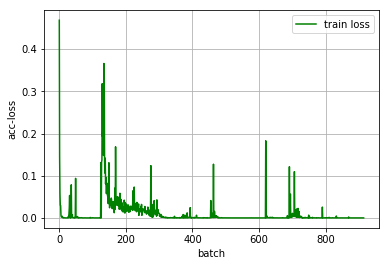

In [18]:
inception(num_class=num_class,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Inception: 100.0%

In [ ]:
output.add('Inception', train_time=timer.get_processing_time(), **history_this.get_best())

### Model 7: InceptionResnet

In [19]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )

Epoch 1/20
183/183 [==============================] - 360s 2s/step - loss: 0.0076 - acc: 0.9980 - val_loss: 0.0172 - val_acc: 0.9954
Epoch 2/20
183/183 [==============================] - 134s 731ms/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0011 - val_acc: 0.9997
Epoch 3/20
183/183 [==============================] - 135s 739ms/step - loss: 2.7842e-04 - acc: 1.0000 - val_loss: 0.2168 - val_acc: 0.9864
Epoch 4/20
183/183 [==============================] - 137s 748ms/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 5/20
183/183 [==============================] - 139s 761ms/step - loss: 6.1971e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 6/20
183/183 [==============================] - 140s 763ms/step - loss: 8.5028e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 00006: early stopping


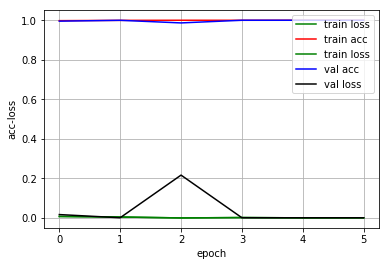

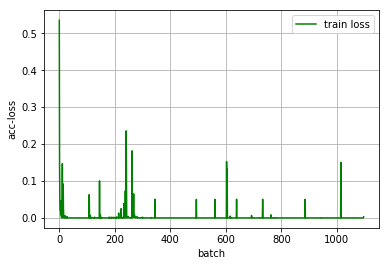

In [20]:
inceptionresnet(num_class=num_class,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of InceptionResnet: 99.993%

In [ ]:
output.add('InceptionResnet', train_time=timer.get_processing_time(), **history_this.get_best())

# Hyperparameter Optimization 
Use VGG16 as an example.  

Tuned hyperparameters of CNN: 
1. The number of frozen layers
2. The number of epochs
3. Early stop patience
4. Learning rate
5. Dropout rate

Hyperparameter optimization methods:
1. Random search
2. Bayesian optimization - Tree Parzen Estimator(BO-TPE)

In [14]:
def prediction(model, test_labels=test_labels, test_images=test_images, label=label):
#read images from validation folder
    # test_labels = []
    # test_images=[]
    # for subdir, dirs, files in os.walk(rootdir):
    #     for file in files:
    #         if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
    #             continue
    #         test_labels.append(subdir.split('/')[-1])
    #         test_images.append(os.path.join(subdir, file))

    # label=validation_generator.class_indices
    # label={v: k for k, v in label.items()}
    # predict=[]
    # length=len(test_images)
    # for i in range(length):
    #     inputimg=test_images[i]
    #     test_batch=[]
    #     thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #     #print(thisimg)
    #     test_shape=(1,)+thisimg.shape
    #     thisimg=thisimg.reshape(test_shape)
    #     model_batch=model.predict(thisimg) #use master model to process the input image
    #     #generate result by model 1
    #     prob=model_batch[0,np.argmax(model_batch,axis=1)[0]]
    #     res=label[np.argmax(model_batch,axis=1)[0]]
    #     predict.append(res)
    acc=accuracy_score(test_labels, get_prediction(model=model, test_images=test_images, label=label))
    return acc

## Model by Own

In [ ]:
def cnn_by_own(num_class,input_shape=INPUT_SIZE,epochs=20,patience=2, dropout_rate=0.5,verbose=0,savepath='./model_own.h5',history=history_this,timer=timer):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=verbose, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[history, timer, earlyStopping, saveBestModel],
        verbose=verbose
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = cnn_by_own(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
cnn_by_own(input_shape=INPUT_SIZE, num_class=num_class, verbose=1, **params)

In [ ]:
output.add('model_own (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
cnn_by_own(input_shape=INPUT_SIZE, num_class=num_class, verbose=1, **params)

In [ ]:
output.add('model_own (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## Xception

In [ ]:
def xception( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model


In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = xception(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
available_frozen = [50, 100, 131]
space = {
    'frozen': hp.choice('frozen', available_frozen),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': available_frozen[int(best['frozen'])],
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
xception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Xception (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
available_frozen = [50, 100, 131]
space = {
    'frozen': hp.choice('frozen', available_frozen),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': available_frozen[int(best['frozen'])],
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
xception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Xception (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## VGG16

In [13]:
def vgg16(num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0, savepath='./VGG16.h5',history=history_this,timer=timer,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
        verbose = verbose
    )
    return model


In [15]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = vgg16(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [16]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


accuracy:0.9842406876790831                           
accuracy:0.9598853868194842                                                         
accuracy:0.9756446991404012                                                         
accuracy:0.9713467048710601                                                       
 40%|████      | 4/10 [20:47<29:57, 299.59s/trial, best loss: -0.9842406876790831]WARNING:tensorflow:Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


accuracy:0.9684813753581661                                                       
accuracy:0.9570200573065902                                                       
 60%|██████    | 6/10 [31:07<20:06, 301.50s/trial, best loss: -0.9842406876790831]WARNING:tensorflow:Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


accuracy:0.9749283667621776                                                       
accuracy:0.9777936962750716                                                       
accuracy:0.9799426934097422                                                       
accuracy:0.9634670487106017                                                       
100%|██████████| 10/10 [51:03<00:00, 306.39s/trial, best loss: -0.9842406876790831]
Hyperopt estimated optimum {'dropout_rate': 0.6000000000000001, 'epochs': 15.0, 'frozen': 16.0, 'lr': 0.002, 'patience': 3.0}
Time: 3063.9442534446716


In [17]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg16(num_class=num_class, verbose=1, **params)

Epoch 1/15
11/44 [======>.......................] - ETA: 20s - loss: 0.2106 - acc: 0.9384
Epoch 00001: val_acc improved from -inf to 0.93840, saving model to ./VGG16.h5
44/44 [==============================] - 36s 825ms/step - loss: 0.8529 - acc: 0.8219 - val_loss: 0.2106 - val_acc: 0.9384
Epoch 2/15
11/44 [======>.......................] - ETA: 19s - loss: 0.1864 - acc: 0.9384
Epoch 00002: val_acc did not improve from 0.93840
44/44 [==============================] - 26s 601ms/step - loss: 0.1814 - acc: 0.9370 - val_loss: 0.1864 - val_acc: 0.9384
Epoch 3/15
11/44 [======>.......................] - ETA: 21s - loss: 0.1434 - acc: 0.9477
Epoch 00003: val_acc improved from 0.93840 to 0.94771, saving model to ./VGG16.h5
44/44 [==============================] - 28s 631ms/step - loss: 0.1554 - acc: 0.9472 - val_loss: 0.1434 - val_acc: 0.9477
Epoch 4/15
11/44 [======>.......................] - ETA: 21s - loss: 0.1229 - acc: 0.9506
Epoch 00004: val_acc improved from 0.94771 to 0.95057, saving m

In [18]:
output.add('VGG16 (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [20]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

accuracy:0.9684813753581661                           
accuracy:0.9684813753581661                                                       
accuracy:0.9756446991404012                                                       
accuracy:0.9670487106017192                                                       
accuracy:0.9806590257879656                                                       
accuracy:0.9813753581661891                                                       
accuracy:0.9820916905444126                                                       
accuracy:0.9792263610315186                                                       
accuracy:0.9584527220630372                                                       
accuracy:0.9777936962750716                                                       
100%|██████████| 10/10 [54:06<00:00, 324.61s/trial, best loss: -0.9820916905444126]
Hyperopt estimated optimum {'dropout_rate': 0.4, 'epochs': 15.0, 'frozen': 18.0, 'lr': 0.004, 'patience': 4.0}
Tim

In [21]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg16(num_class=num_class, verbose=1, **params)

Epoch 1/15
11/44 [======>.......................] - ETA: 19s - loss: 0.2843 - acc: 0.9463
Epoch 00001: val_acc improved from -inf to 0.94628, saving model to ./VGG16.h5
44/44 [==============================] - 41s 924ms/step - loss: 0.5985 - acc: 0.8416 - val_loss: 0.2843 - val_acc: 0.9463
Epoch 2/15
11/44 [======>.......................] - ETA: 19s - loss: 0.1756 - acc: 0.9542
Epoch 00002: val_acc improved from 0.94628 to 0.95415, saving model to ./VGG16.h5
44/44 [==============================] - 27s 613ms/step - loss: 0.2357 - acc: 0.9418 - val_loss: 0.1756 - val_acc: 0.9542
Epoch 3/15
11/44 [======>.......................] - ETA: 19s - loss: 0.1313 - acc: 0.9620
Epoch 00003: val_acc improved from 0.95415 to 0.96203, saving model to ./VGG16.h5
44/44 [==============================] - 27s 609ms/step - loss: 0.1636 - acc: 0.9588 - val_loss: 0.1313 - val_acc: 0.9620
Epoch 4/15
11/44 [======>.......................] - ETA: 19s - loss: 0.1156 - acc: 0.9642
Epoch 00004: val_acc improved f

In [22]:
output.add('VGG16 (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## VGG19

In [ ]:
def vgg19( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        verbose=verbose,
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model


In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = vgg19(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg19(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('VGG19 (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
vgg19(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('VGG19 (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## ResNet

In [ ]:
def resnet( num_class, epochs=20,frozen=120,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE,timer=timer):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = resnet(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
resnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('ResNet (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
resnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('ResNet (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## Inception

In [ ]:
def inception( num_class, epochs=20,frozen=120,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = inception(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Inception (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 50, 150, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inception(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('Inception (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

## InceptionResnet

In [ ]:
def inceptionresnet( num_class, epochs=20,frozen=120,lr=0.001,patience=2, dropout_rate=0.5,verbose=0,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE, timer=timer):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto', restore_best_weights=True)	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        verbose=verbose,
        callbacks=[history, timer, earlyStopping, saveBestModel],
    )
    return model

In [ ]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params, num_class=num_class, history=history_hpo):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    # frozen=params['frozen']
    # epochs=params['epochs']
    # patience=params['patience']
    # lr=params['lr']
    # dropout_rate=params['dropout_rate']

    # vgg16(num_class=num_class, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    model = inceptionresnet(num_class=num_class, history=history, **params)

    acc=prediction(model=model)

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

### BO-TPE

In [ ]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 400, 500, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inceptionresnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('InceptionResnet (BO-TPE)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

### Random Search

In [ ]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 400, 500, 10),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

In [ ]:
# Retrain the model by using the best hyperparameter values to obtain the best model
params = {
        'frozen': int(best['frozen']),
        'epochs': int(best['epochs']),
        'patience': int(best['patience']),
        'lr': abs(float(best['lr'])),
        'dropout_rate': abs(float(best['dropout_rate'])),
    }
inceptionresnet(num_class=num_class, verbose=1, **params)

In [ ]:
output.add('InceptionResnet (Random Search)', hpo_time=t2-t1, train_time=timer.get_processing_time(), **history_this.get_best())

# Save Result

In [24]:
output.to_excel()

In [ ]:
# Online GPU renting platform specification
# WeChat Message
import requests
resp = requests.get(
    "https://www.autodl.com/api/v1/wechat/message/push?token={token}&title={title}&name={name}&content={content}".format(
        token="add7ba8eea4b",
        title="From AutoDL",
        name="UNSW-NB15 CNN",
        content="Training Complete")
)
print(resp.content.decode())
# Shutdown
!shutdown